# Calculate Compound Years for CESM

This file grabs the warm season indeces and sees if this shows us anything


You need to run cesmTradIndeces.ipnyb first (which in turn requires calculateCesmMonthlyIndeces.ipnyb)

In [1]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
from utils.timePeriod import averageForTimePeriod


In [2]:
import xarray
import matplotlib.pyplot as plt

In [3]:
# Here is the data

indecesDa = xarray.load_dataarray('results/cesmTradIndeces.nc')

In [4]:
indecesDa.experiment

<xarray.DataArray 'experiment' (experiment: 18)>
array(['0850cntl.001', 'LME.002', 'LME.003', 'LME.008', 'LME.009', '001',
       '002', '003', '004', '005', '006', '007', '008', '009', '010', '011',
       '012', '013'], dtype=object)
Coordinates:
  * experiment  (experiment) object '0850cntl.001' 'LME.002' ... '012' '013'

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

For now, using a 850-1850 climatology

In [5]:
# This should calcate stds for all experiments and all indeces
stdDa = indecesDa.std(dim='year')

In [6]:
stdDa

<xarray.DataArray (experiment: 18, index: 8)>
array([[0.83858966, 1.19973666, 1.23498488, 1.01658832, 0.5405698 ,
        0.85341983, 0.98433009, 1.31134252],
       [1.03332804, 1.38493881, 1.40264867, 1.18156687, 0.81154454,
        0.97695892, 0.97121338, 1.29915917],
       [0.99234622, 1.31875528, 1.34342269, 1.14017915, 0.81818335,
        0.97906509, 0.97072253, 1.30906154],
       [1.04906898, 1.39068065, 1.38913455, 1.1406317 , 0.80769504,
        0.98101418, 0.96289501, 1.32960838],
       [1.0811824 , 1.40105812, 1.3903454 , 1.14195714, 0.80971254,
        1.02186586, 0.97476821, 1.32207028],
       [0.86282581, 1.21924261, 1.23938647, 1.01041567, 0.5498468 ,
        0.82720132, 0.94141072, 1.3073965 ],
       [0.85977486, 1.22589927, 1.24982981, 1.02749435, 0.55377056,
        0.83350374, 0.96516294, 1.2894376 ],
       [0.82098458, 1.156042  , 1.18410072, 0.98239616, 0.55622096,
        0.84210256, 0.96452911, 1.29269306],
       [0.88050153, 1.22565126, 1.21981798, 0.98172168, 0.55021146,
        0.84737954, 0.96710452, 1.31449539],
       [0.85188256, 1.1834065 , 1.19292384, 0.97830024, 0.54668684,
        0.81935437, 0.94379253, 1.28634667],
       [0.84901384, 1.1894003 , 1.19636458, 0.97828464, 0.5462003 ,
        0.84485661, 0.95866814, 1.29209167],
       [0.8211952 , 1.15854383, 1.18333426, 0.99155094, 0.54226064,
        0.8374271 , 0.96433356, 1.30622782],
       [0.85809711, 1.20527431, 1.2173261 , 0.98500056, 0.5522818 ,
        0.83193274, 0.95466857, 1.32188974],
       [0.88894045, 1.22167555, 1.2307467 , 1.00161114, 0.5544567 ,
        0.85972802, 0.97134624, 1.29889065],
       [0.81613344, 1.15515179, 1.18475326, 0.98261132, 0.53767376,
        0.81144524, 0.92893699, 1.31440653],
       [0.89431503, 1.24557112, 1.25132272, 1.01042708, 0.55650611,
        0.84586593, 0.96171318, 1.33490811],
       [0.83557584, 1.18454187, 1.21144229, 1.00572077, 0.55140931,
        0.83757877, 0.96434546, 1.29641557],
       [0.86420447, 1.20675291, 1.21736741, 0.99075873, 0.55710597,
        0.85039628, 0.97066201, 1.29462718]])
Coordinates:
  * index       (index) object 'nino12' 'nino3' ... 'indian_ocean_dipole' 'sam'
  * experiment  (experiment) object '0850cntl.001' 'LME.002' ... '012' '013'

In [7]:
criteriaDa = xarray.concat(
    (
        stdDa.sel(index=['nino34','indian_ocean_dipole']),
        stdDa.sel(index='sam')/2
    ),
    'index'
)

In [15]:
posEvents=indecesDa>criteriaDa
negEvents=indecesDa<-criteriaDa

Do we believe it? That was very easy

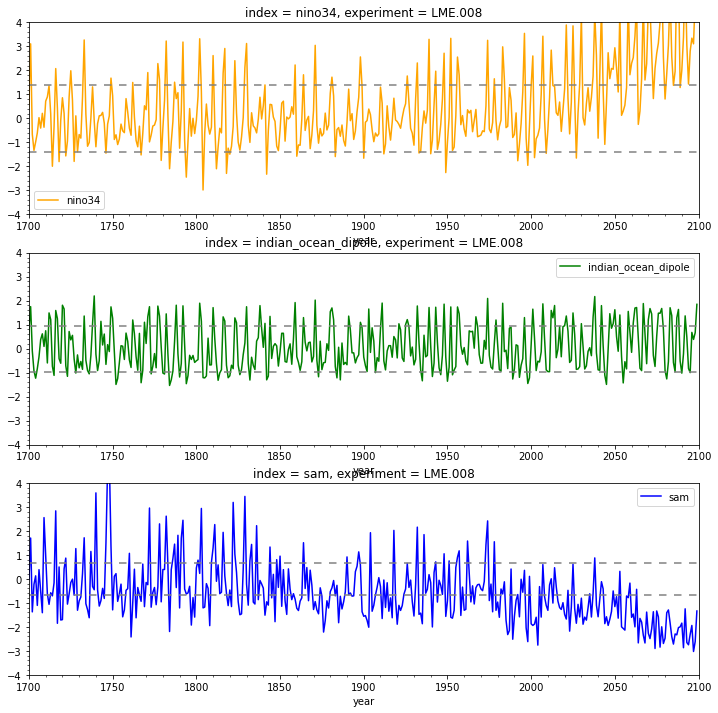

In [17]:
# plot indeces for an experiment, and add some lines for +- 1 sigma

expToPlot = 'LME.008'

indexToPlot = ['nino34', 'indian_ocean_dipole', 'sam']

colors = ['orange', 'green', 'blue']

# first define somewhere to plot
fig = plt.figure(figsize=(12,12))

for i in range(3):
    
    ax = fig.add_subplot(3,1,i+1)

    # plot the actual data
    indecesDa.sel(
        experiment=expToPlot,
        index=indexToPlot[i]
    ).plot(
        label=indexToPlot[i],
        ax=ax, 
        color=colors[i]
    )

    # draw some horizontal lines for +- 1 sigma
    plt.axhline(
        y=criteriaDa.sel(experiment=expToPlot, index=indexToPlot[i]),
        dashes=(5,5),
        color='grey'
    )
    plt.axhline(
        y=-criteriaDa.sel(experiment=expToPlot, index=indexToPlot[i]),
        dashes=(5,5),
        color='grey'
    )

#Tidy up a bit
#plt.title("CESM Full Forcing Ensemble Run 001")
    plt.ylim(-4,4)
    plt.minorticks_on()
    plt.legend()
    
    plt.xlim(1700,2100)